# Intro

This notebook is used for exploratory data analysis (EDA) purposes to better understand the dataset and identify features of interest and importance. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Read the training data in
train_data = pd.read_csv('./data/train.csv')

The first thing I do is get a quick summary of the columns and see what I'm dealing with. I also examine the shape of the data and explore the data types.

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We see columns with a variety of different types (ints, doubles, strings) and even some that may be all null.

In [4]:
# Get the shape of the data
train_data.shape

(1460, 81)

There are 1460 observations in this training set and 79 features (excluding Id and SalePrice which is the target varaible)

In [5]:
features = train_data.drop(['SalePrice', 'Id'], axis=1)
target = train_data['SalePrice']

In [6]:
features.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

We see that a lot of the columns are categorical variables (dtypes is equal to object).

The next thing to look at are all the columns that have some null values. We do that below. The first counts how many nulls are present in each column and the second orders the features from most nulls to least, excluding features that don't have any nulls.

In [7]:
null_counts = train_data.isnull().sum(axis=0)
non_null_column_counts = null_counts[null_counts > 0] / train_data.shape[0]

In [8]:
len(non_null_column_counts)

19

We can see that 19 columns have at least one null present. Let's now order them from highest percentage of null to lowest percentage of null.

In [9]:
non_null_column_counts.sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

Wow! Some features like PoolQC and MiscFeature are over 95% null! Those features will clearly not be any help to us. Since we _want_ to decrease our feature set, let's remove all features that are over 80% null (besides, there is a huge drop from that point on).

NOTE: I could have just passed the colums as a list, but I wanted to do it programmatically instead

In [10]:
# Drop the four features that are > 0.80% null
features_not_null = features.drop(non_null_column_counts[non_null_column_counts > 0.8].index, axis=1)

Now that we've identified the features that have data, let's split our analysis between the categorical features and the numerical ones.

## Categorical Features EDA

The first thing to do is extract the categorical features! This isn't hard as we just need to pull out the columns whose datatype is object. 

In [11]:
categorical_col_names = features_not_null.columns[features_not_null.dtypes == object]
categorical_features = features_not_null[categorical_col_names]

In [12]:
categorical_features.shape

(1460, 39)

Same number of rows, but only 39 features. This tells us that the four features we dropped for being all null were categorical features. 

Besides looking at nulls, the next thing I usually do when examining cateogrical features is examining the value counts across the different features. Features that only have one or two values -- especially when the data is skewed towards one value -- will probably not be helpful. Again since the goal is removing features, identifying features with low variability can be helpful. 

Thus, step one is to identify the unique number of values for each feature. 

In [13]:
nunique_counts = categorical_features.nunique()
nunique_counts.sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
SaleCondition     6
BsmtFinType2      6
RoofStyle         6
BsmtFinType1      6
Foundation        6
Heating           6
GarageType        6
MSZoning          5
BldgType          5
ExterCond         5
LotConfig         5
GarageCond        5
Electrical        5
GarageQual        5
FireplaceQu       5
HeatingQC         5
LotShape          4
LandContour       4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
PavedDrive        3
LandSlope         3
GarageFinish      3
Utilities         2
CentralAir        2
Street            2
dtype: int64

How many features have five or fewer unique values? The answer is below 

In [14]:
len(nunique_counts[nunique_counts < 6])

23

23 features out of 39 features have five or fewer unique values and that is quite a lot. Of course, a feature only having three values is not indicative that a feature cannot be useful. To make my life easier, I decided to plot different characteristics of each feature. Specifically, for every feature, I plot: (A) A countplot across the different values, (B) A vilon plot of SalePrice (target variable)  as a function of different values wiwth the feature and (C) Mean and Median SalePrice as a function of the different values within the feature. By combining all three plots together, I can quickly get a grasp on whether a categorical variable is potentially useful for my algorithm. 

In [15]:
# https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index
# https://stackoverflow.com/questions/30984167/python-pandas-pd-melt-a-dataframe-with-datetime-index-results-in-nan

# Helper function used to plot the third plot, Mean and Median as a function of 
# different values within a categorical feature
def melt_df(df, col):
    result = df[[col, 'SalePrice']].groupby(col).agg({'mean', 'median'})
    result.columns = result.columns.droplevel()
    processed_result = result.stack().reset_index()
    processed_result.columns = [col, 'stat', 'saleprice']
    return processed_result

# The main function, this creates a plot with three subplots: 
# (A) Countplot of different values within the feature
# (B) Violin plot of distribution of sale price as a function of different values within the feature
# (C) Mean and Median Sale Price as a function of the values within the feature
def plot_categorical_features(df, col):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    saleprice_df = melt_df(df, col)
    sns.countplot(x=col, data=df, ax=ax1).set_title('(A) Countplot of every value\nin {}'.format(col))
    sns.violinplot(x=col, 
                   y='SalePrice', 
                   data=df, ax=ax2).set_title('(B) Violin Plot of Sale Price\n as a function of {}'.format(col))
    sns.barplot(x=saleprice_df[col], 
                y=saleprice_df['saleprice'], 
                hue=saleprice_df['stat'], ax=ax3).set_title('(C) Mean and Median Sale Price\nas a function of {}'.format(col))
    
    plt.show()

Armed with this function, I decided to plot the data for all features that had five or fewere values. Results are below. 

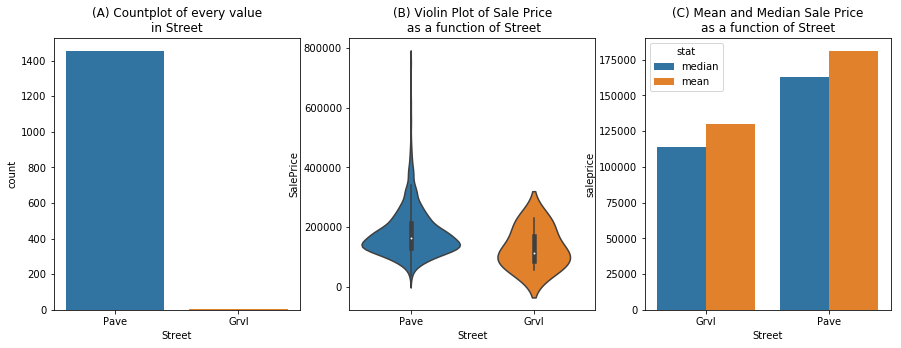

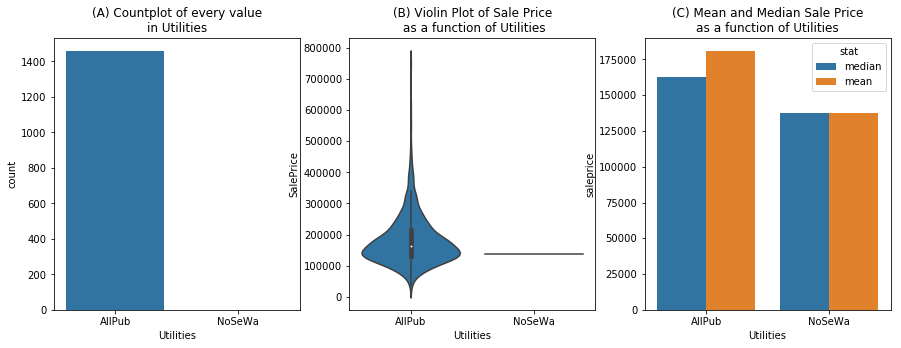

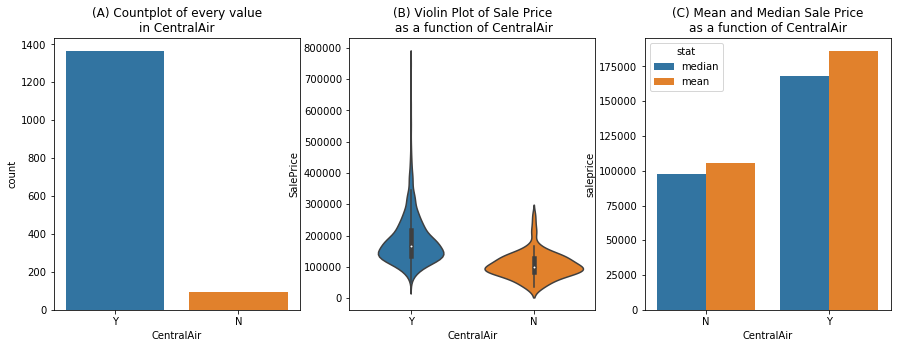

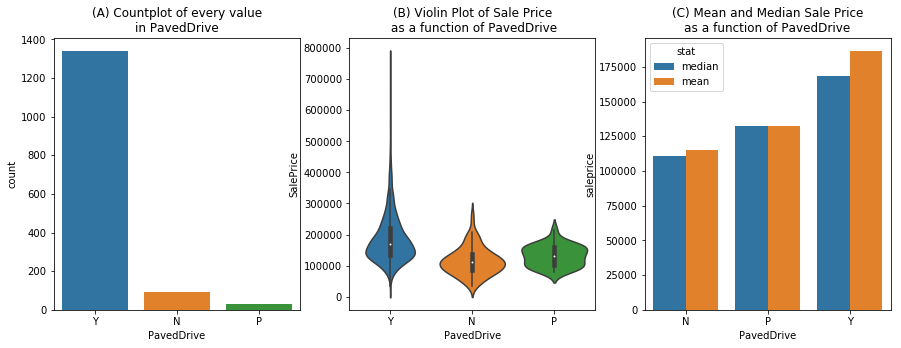

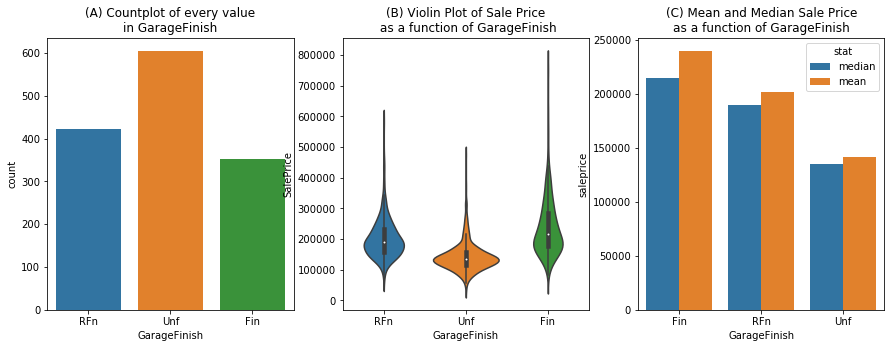

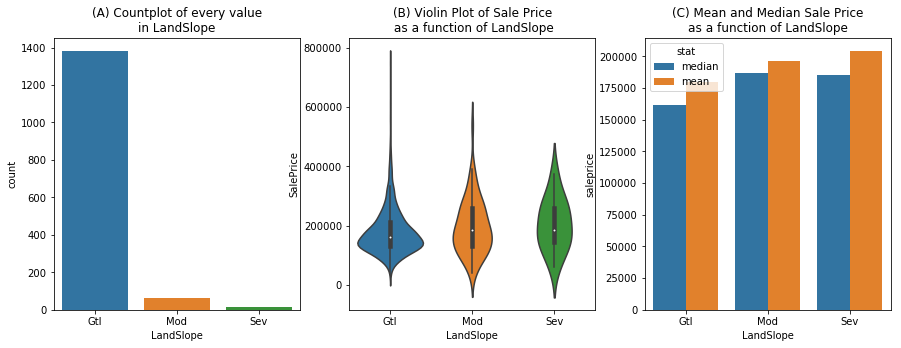

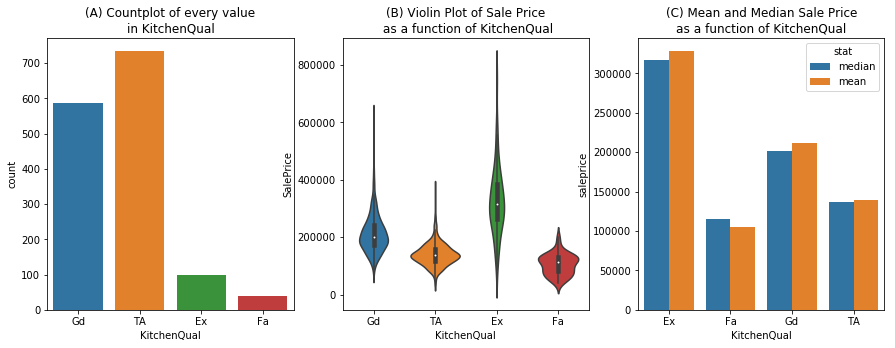

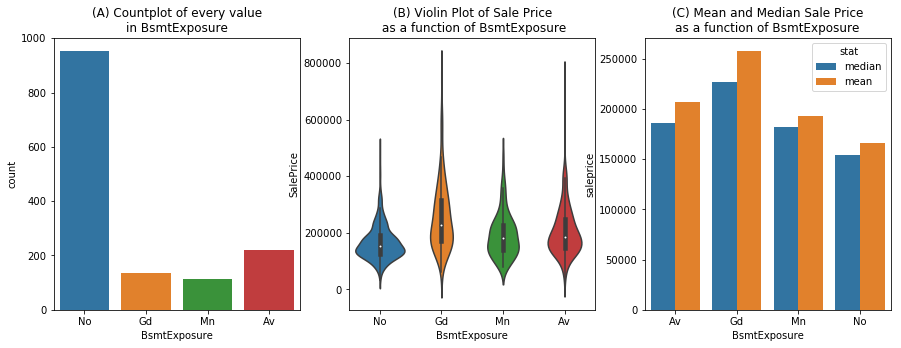

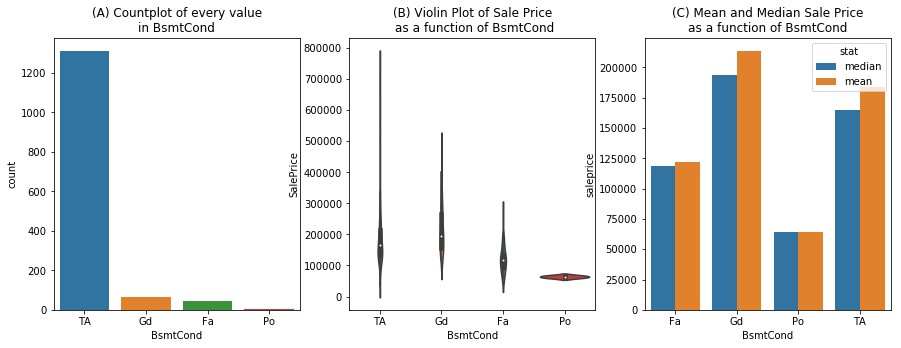

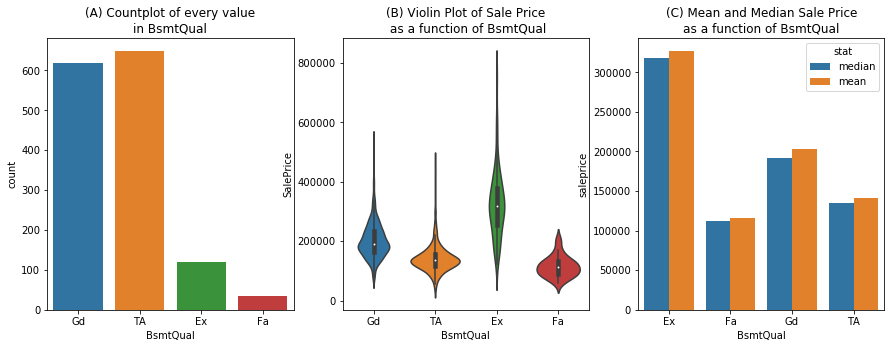

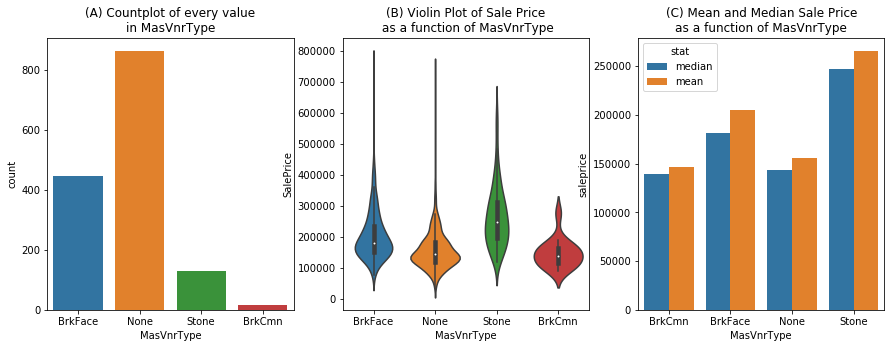

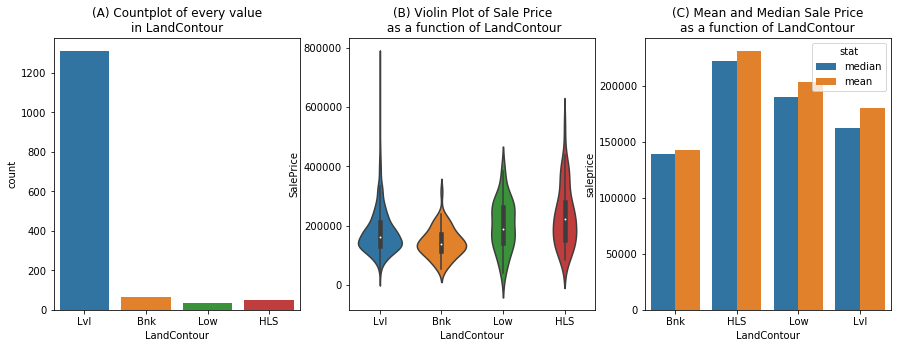

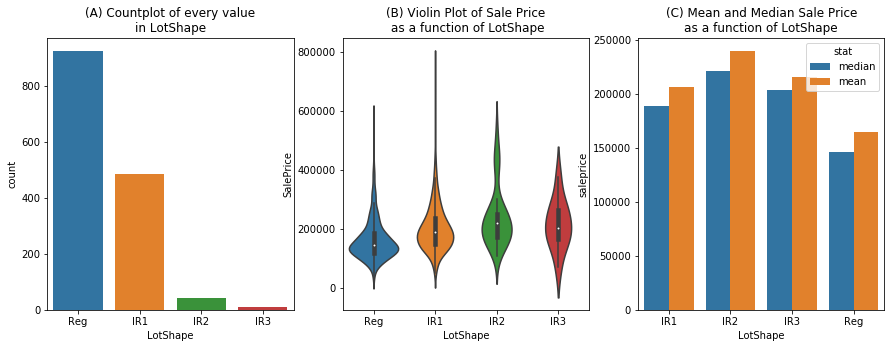

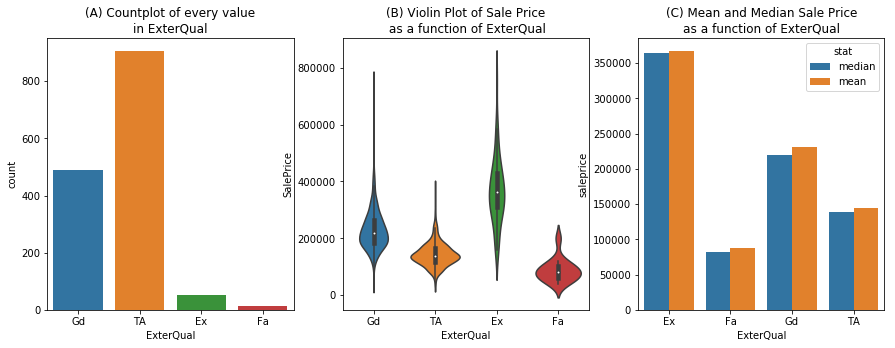

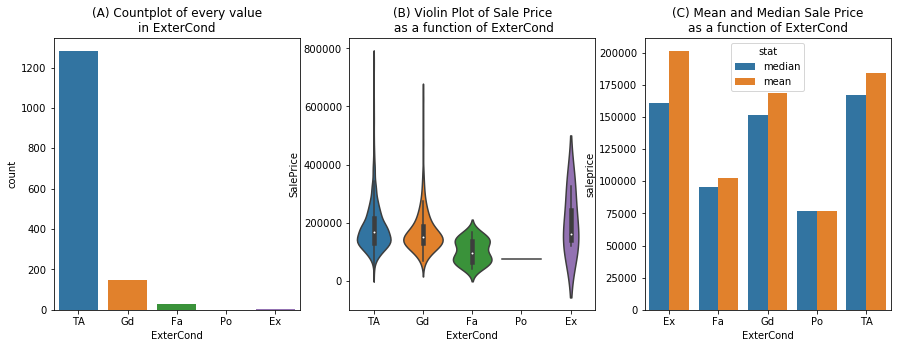

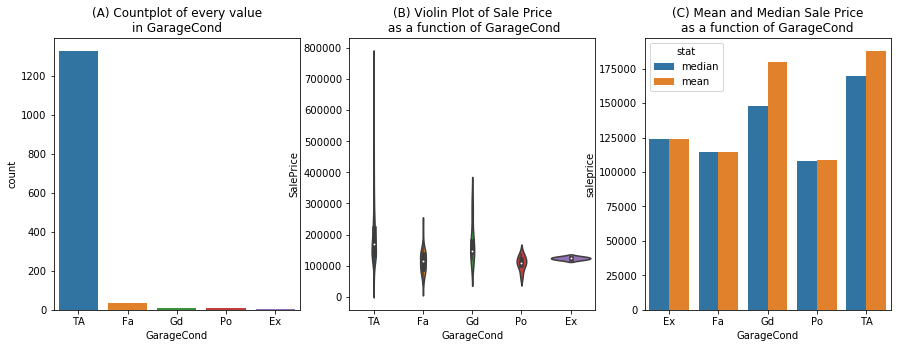

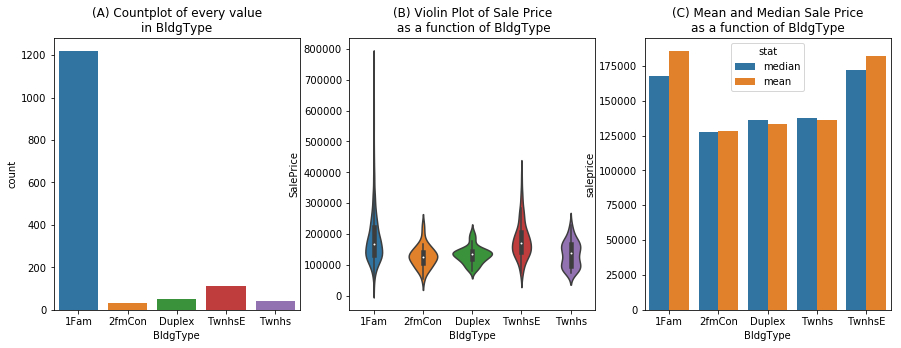

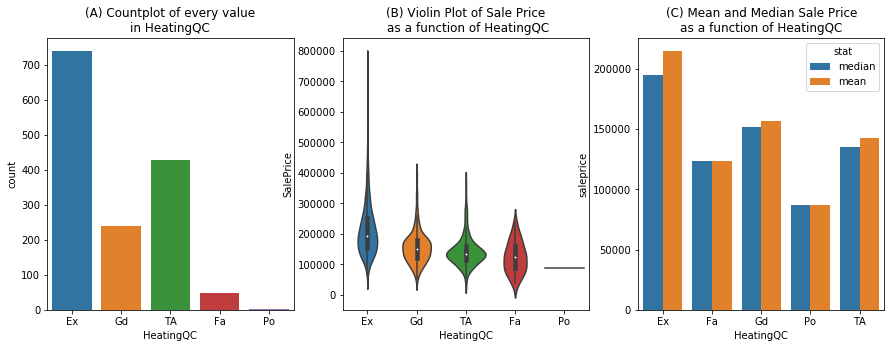

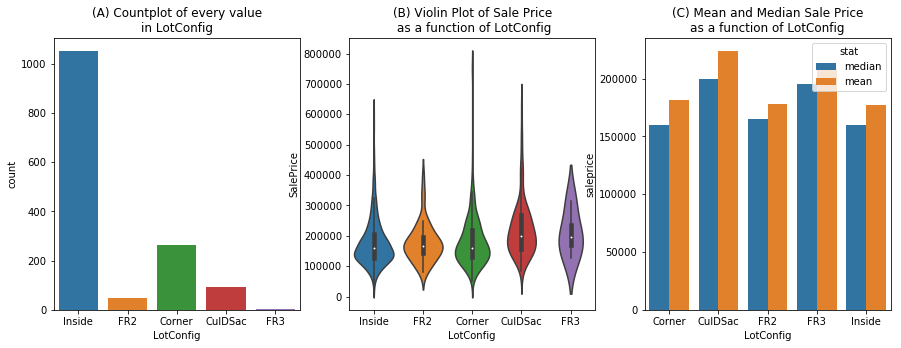

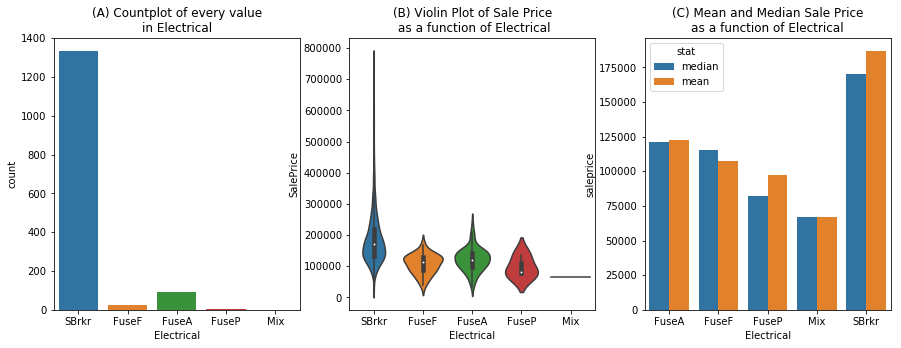

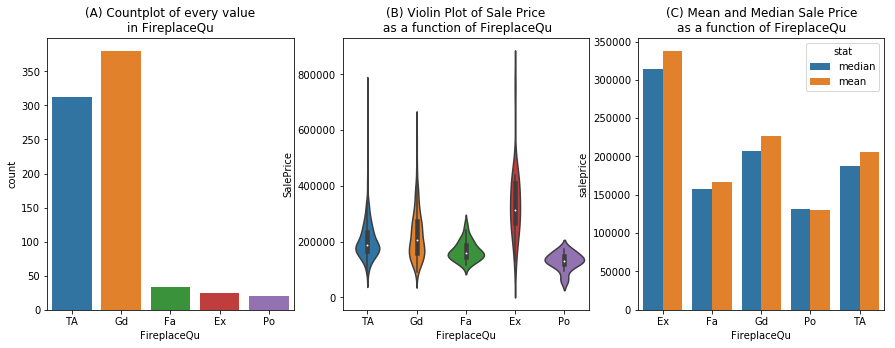

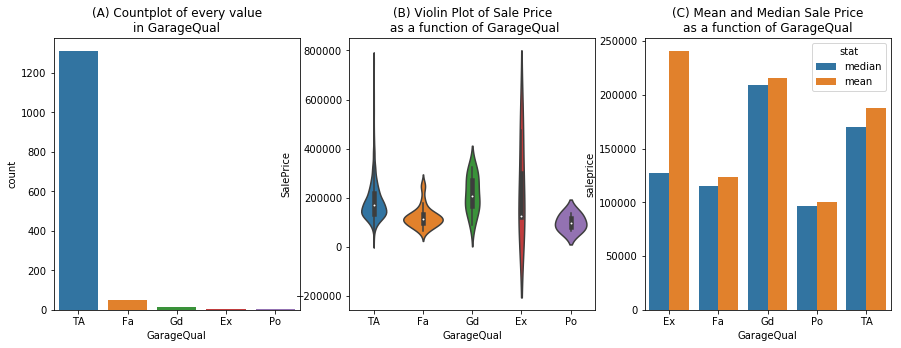

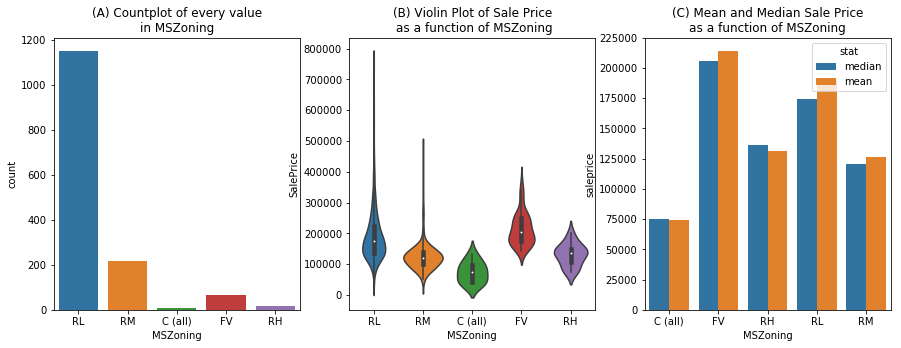

In [16]:
for col in nunique_counts[nunique_counts < 6].sort_values().index: 
    plot_categorical_features(train_data, col)

In [17]:
# Quick calculation to prove a point that certain features are too skewed to be useful. 
train_data['GarageQual'].value_counts() 

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

I know there are a lot of plots and a lot of features but scanning through isn't that difficult. In fact, it's fairly easy to eliminate most features because they're so skewed towards one value (like `GarageQual`, where over 1300 of its 1460 samples have the same value). If I had to pick certain features that might be promising--and I don't really want to because of how skewed they are--it would probably have to be `ExterQual`, `BsmtQual`, and `KitchenQual`.

Of course, now that we dealt with the features that had five or fewer values, it was time to deal with the features that had 6 or more. Since I already had my plot function, I thought I would use it once again here. 

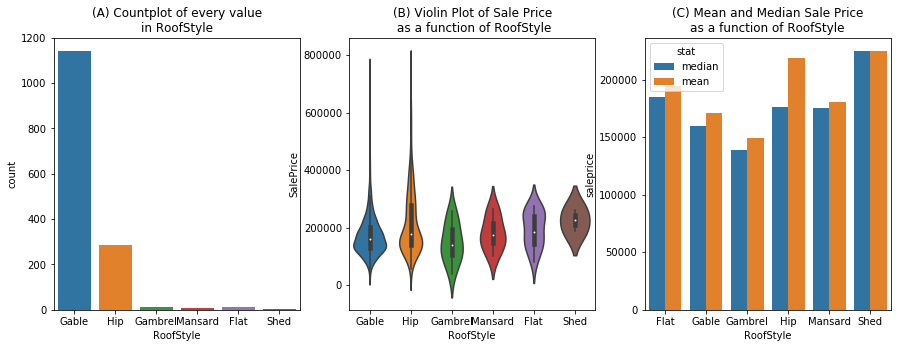

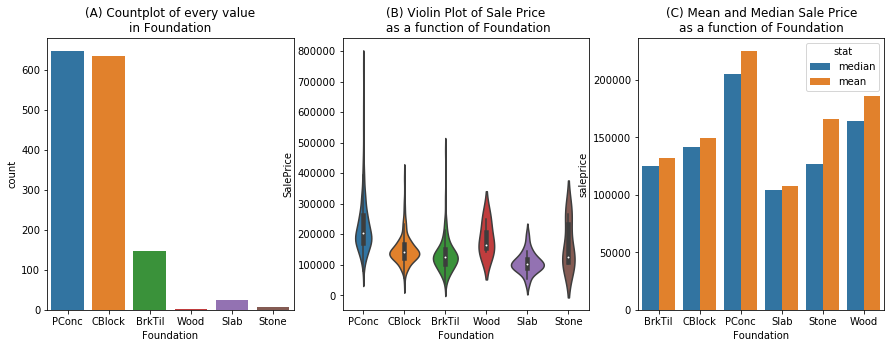

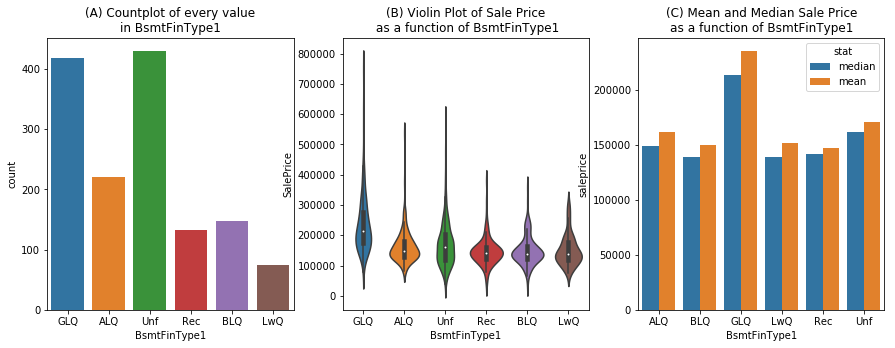

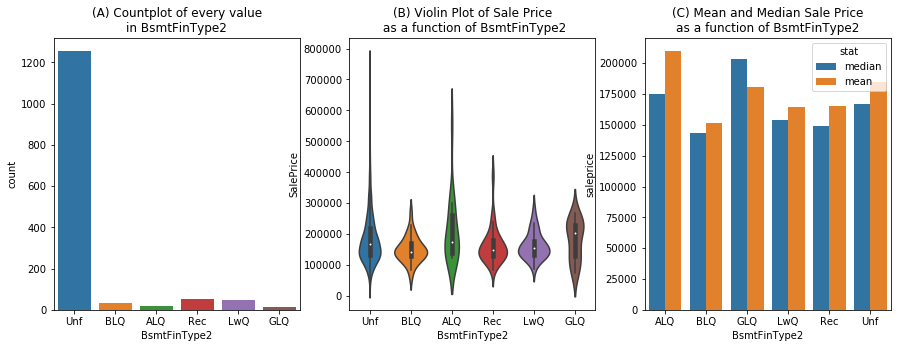

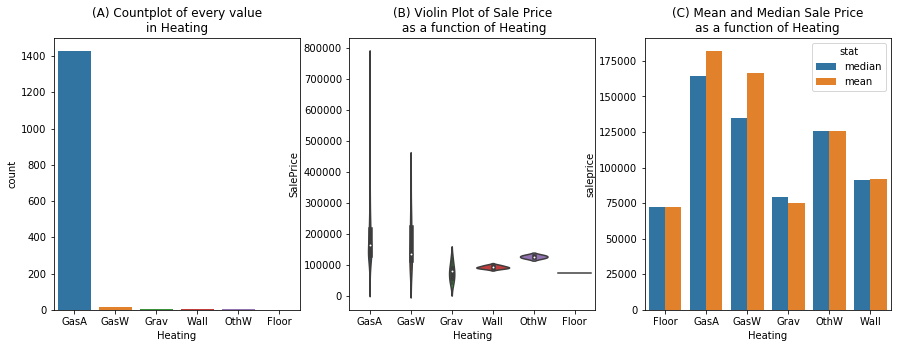

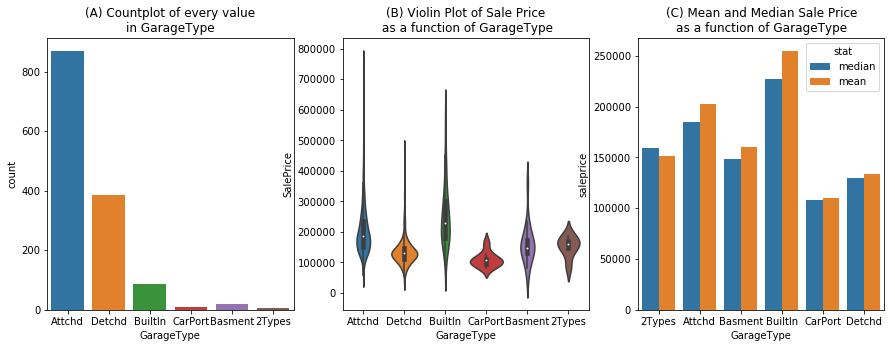

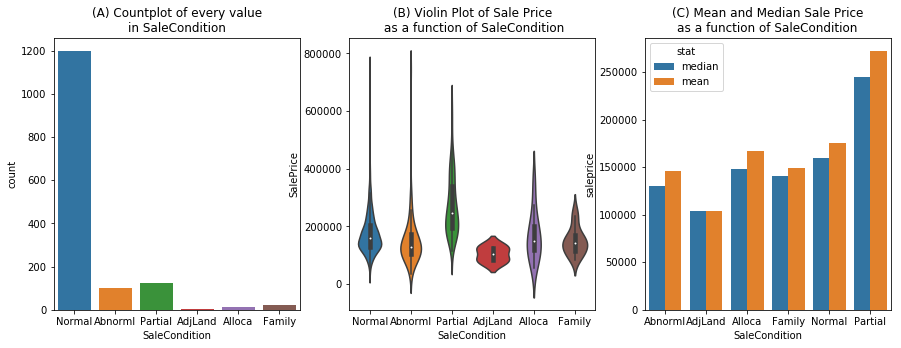

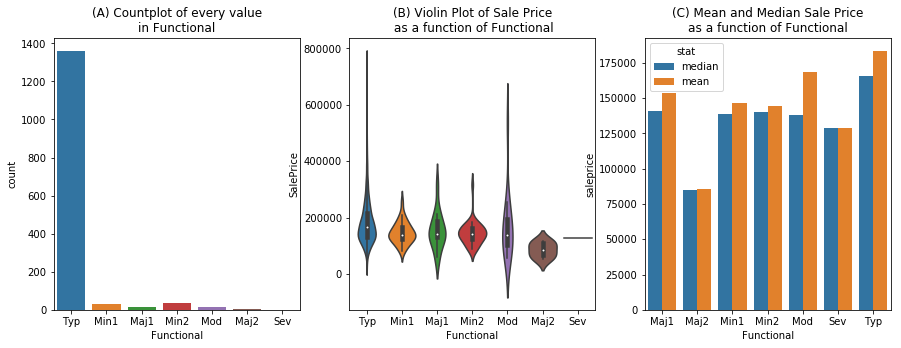

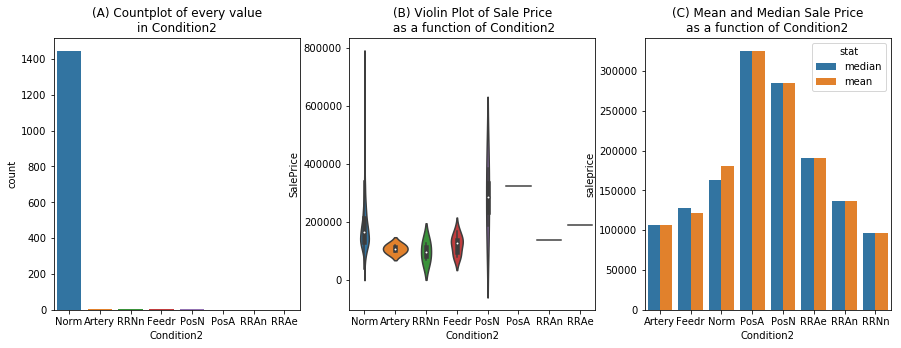

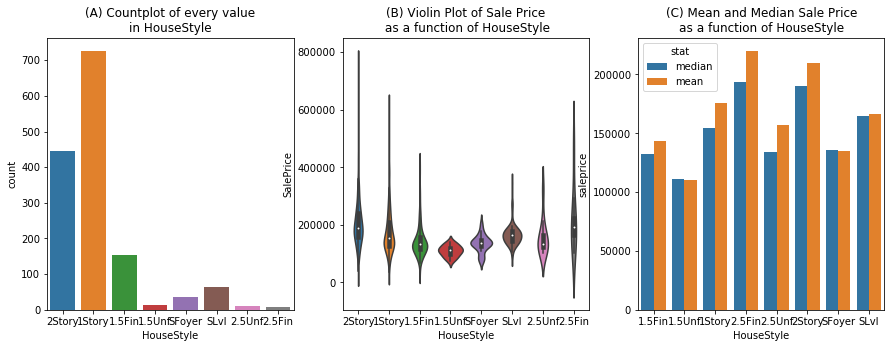

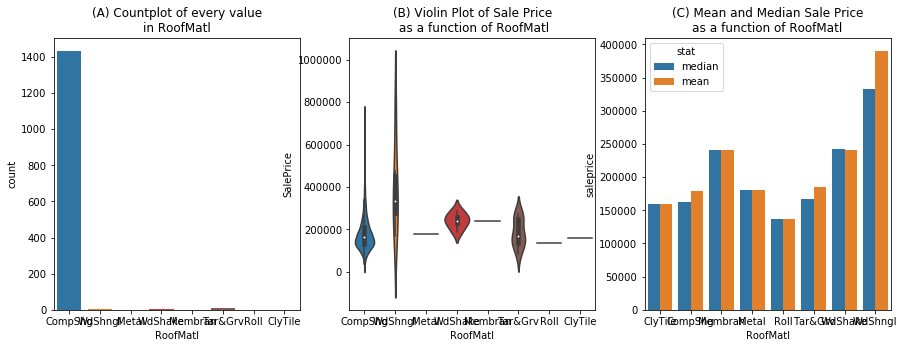

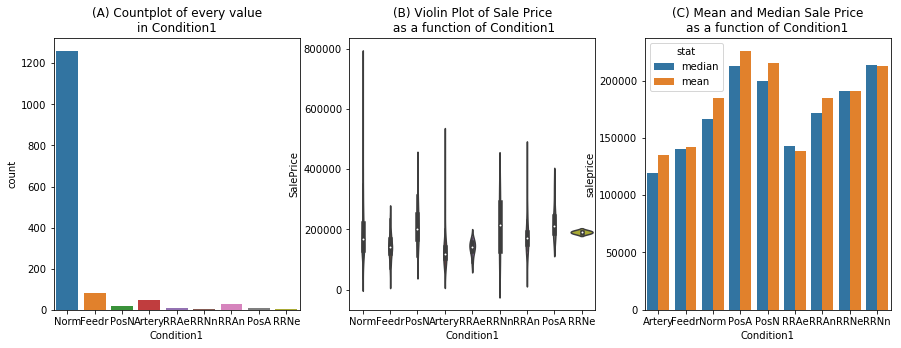

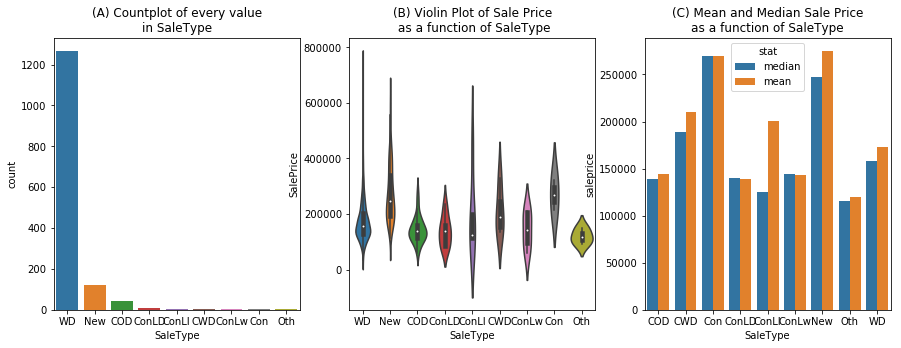

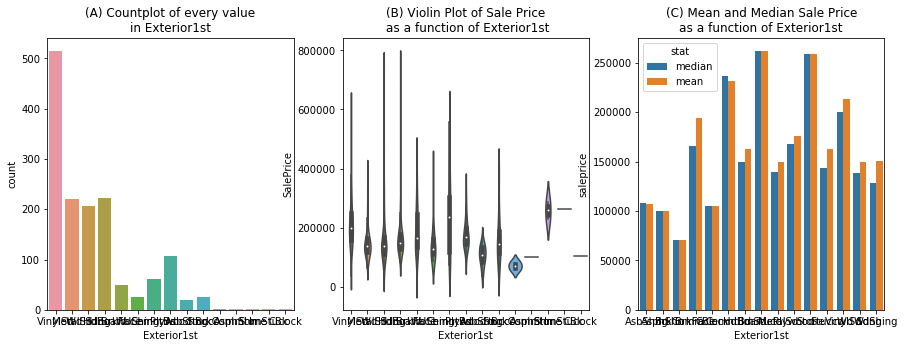

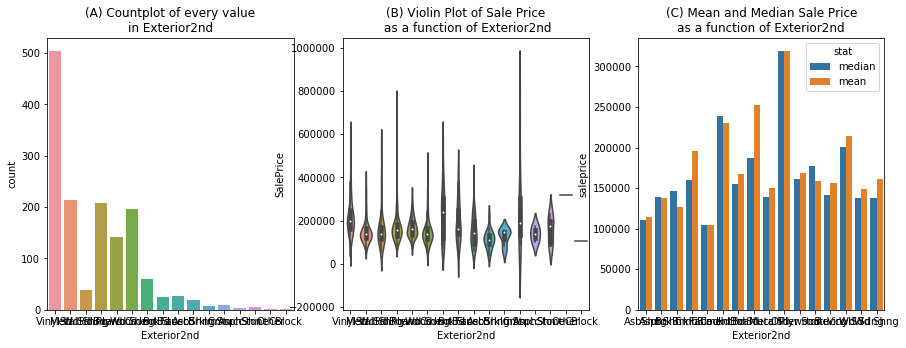

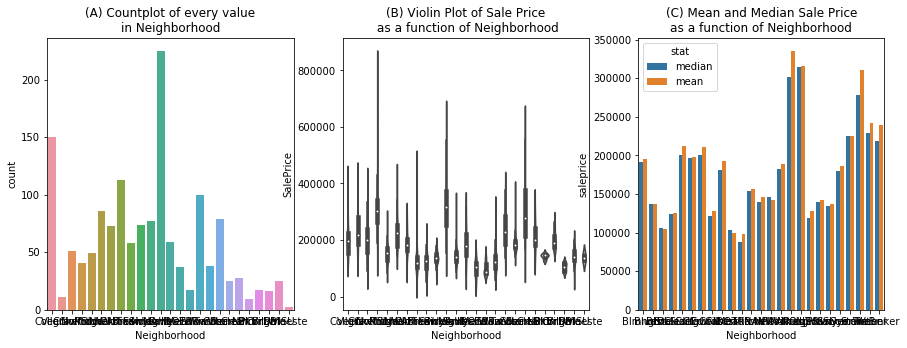

In [18]:
for col in nunique_counts[nunique_counts >= 6].sort_values().index: 
    plot_categorical_features(train_data, col)

I'll be the first to admit, some of these plots are hard to read -- especially the ones that have over 10 values within a feature. Having said that, I'm perfectly okay with that because we can still get a good sense of which features may be useful based on the variation and the `SalePrice` distributions within them. And of these features, only `Neighborhood` really strikes me as a useful feature. Of course, my choice is also based on my intuition--when it comes to housing prices, it's all about location, location, location!

Now that we have examined the categorical features, it is time to examine the numeric features as well

## Continuous Features EDA

### Summary statistics

The first thing I do when examine continuous/numeric features is to plot a sample of the dataframe and generate summary statistics for each of the features. 

In [19]:
continuous_cols = features_not_null.columns[features_not_null.dtypes != object]
continuous_features = features_not_null[continuous_cols]

In [20]:
continuous_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [21]:
cont_summary = continuous_features.describe()
cont_summary

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Wow, there is a lot of features and they all have different distributions. I can't put all of this in the report, but I wonder if I can select 4-5 features that highlight various issues. Let's see if I can identify some interesting features. 

The first features to look out for are thoese that have some null values. We can easily find that by looking at the count, which doesn't include null values.

In [22]:
cont_summary[cont_summary.columns[cont_summary.loc['count'] < 1460]]

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


It looks like three features fall under this category. If I were to include them, I would have to consider some imputation methods

Another thing to look for are features of different order of magnitudes. Let's look for features whose values are different order of magnitudes.

In [23]:
cont_summary[cont_summary.columns[cont_summary.loc['max'] < 10]]

,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,5.575342,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,0.613014,1.767123
std,1.112799,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.644666,0.747315
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000
50%,5.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
max,9.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,3.000000,4.000000


In [24]:
cont_summary[cont_summary.columns[(cont_summary.loc['max'] < 1000) & (cont_summary.loc['min'] > 10)]]

,MSSubClass,LotFrontage
count,1460.000000,1201.000000
mean,56.897260,70.049958
std,42.300571,24.284752
min,20.000000,21.000000
25%,20.000000,59.000000
50%,50.000000,69.000000
75%,70.000000,80.000000
max,190.000000,313.000000


In [25]:
cont_summary[cont_summary.columns[cont_summary.loc['min'] > 1000]]

,LotArea,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000
mean,10516.828082,1971.267808,1984.865753,1978.506164,2007.815753
std,9981.264932,30.202904,20.645407,24.689725,1.328095
min,1300.000000,1872.000000,1950.000000,1900.000000,2006.000000
25%,7553.500000,1954.000000,1967.000000,1961.000000,2007.000000
50%,9478.500000,1973.000000,1994.000000,1980.000000,2008.000000
75%,11601.500000,2000.000000,2004.000000,2002.000000,2009.000000
max,215245.000000,2010.000000,2010.000000,2010.000000,2010.000000


Wow! Lots of variability once again. This is definitely good to know, especially in cases where magnitudes and scales matter. 

Finally, the last thing to look for are skewed variables. Many variables in finance seem to have a long tail to the right so one quick heuristic to identify such features is to find features whose 75% is still 0, which I do below.

In [26]:
cont_summary[cont_summary.columns[cont_summary.loc['75%'] == 0]]

,BsmtFinSF2,LowQualFinSF,BsmtHalfBath,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,46.549315,5.844521,0.057534,21.954110,3.409589,15.060959,2.758904,43.489041
std,161.319273,48.623081,0.238753,61.119149,29.317331,55.757415,40.177307,496.123024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1474.000000,572.000000,2.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


And viola! We have found 10 features that seemed to be skewed right. Putting everything I've discovered above, five features that are most interesting to highlight are the ones below: 

In [27]:
cont_summary[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'BsmtFinSF2']]

,MSSubClass,LotFrontage,LotArea,OverallCond,BsmtFinSF2
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,5.575342,46.549315
std,42.300571,24.284752,9981.264932,1.112799,161.319273
min,20.000000,21.000000,1300.000000,1.000000,0.000000
25%,20.000000,59.000000,7553.500000,5.000000,0.000000
50%,50.000000,69.000000,9478.500000,5.000000,0.000000
75%,70.000000,80.000000,11601.500000,6.000000,0.000000
max,190.000000,313.000000,215245.000000,9.000000,1474.000000


Again the reason I selected these features is because they examplify different things to watch out for. `LotFrontage` forces us to pay attention to null values; `BsmtFinSF2` forces us to pay attention to skew; and `LotArea`, `OverallCond`, and `LotFrontage` forces us to be aware of the magnitude and scale of our units. 

### Skew

Before continuing, I want to go back and discuss skew. Many algorithms assume that features follow a normal distribution so the presence of skew can really throw things off. For my own curiosity, I wanted to identify the most skewed feature and plot its distribution. We can do easily do that as follows: 

In [28]:
# https://stackoverflow.com/questions/45483890/how-to-correctly-use-scipys-skew-and-kurtosis-functions
from scipy.stats import skew
import numpy as np

skew_results = skew(continuous_features, nan_policy='omit')
skew_results

masked_array(data = [  1.40621011   2.16086599  12.19514213   0.21672098   0.69235521
  -0.61283072  -0.5030445    2.6663261    1.6837709    4.25088802
   0.9193227    1.52268809   1.37534174   0.81219427   9.00208042
   1.36515595   0.59545404   4.09918567   0.03652398   0.67520283
   0.21157244   4.48378409   0.67564577   0.64889763  -0.64870801
  -0.3421969    0.17979594   1.5397917    2.36191193   3.08669647
  10.29375236   4.11797738  14.81313466  24.45163962   0.21183506
   0.09616958],
             mask = False,
       fill_value = 1e+20)

The higher the value, the worse the skew. Identifying the most skewed feature programatically is straightforward:

In [29]:
feature_max_skew = continuous_features.columns[np.nanargmax(skew_results)]
feature_max_skew

'MiscVal'

Now that we know this, let's plot it.

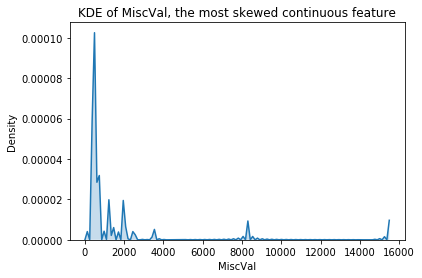

In [30]:
sns.kdeplot(continuous_features[feature_max_skew], shade=True, legend=False).set_title('KDE of MiscVal, the most skewed continuous feature') 
plt.xlabel('MiscVal') 
plt.ylabel('Density')

That's a long tail! If we wanted to use this feature, we definitely would have to transform it (perhaps log transform?) it first. 

Of course, at this point, we've only focused on our features. But skewness can also impact our target variable. Let's plot the distribution of `SalePrice` and see what its distribution is. 

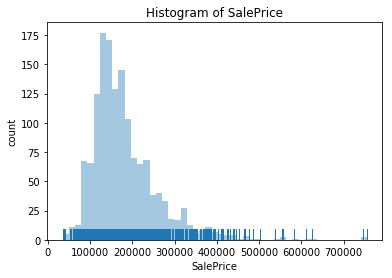

In [31]:
sns.distplot(target, kde=False, rug=True).set_title('Histogram of SalePrice')
plt.ylabel('count')

Wow! That is skewed right as well. Very likely, we will probably have to take the log transform of our target variable as well. 

### Correlations, heatmaps, and pairplots

Great, we definitely have a lot better sense of the distributions of our features. But when I'm really trying to figure out which continuous features I'm trying to use, I always go with correlations. Let's see what the correlations look like across the different features and our target variable:

In [32]:
corr_df = train_data.drop(['Id'], axis=1)
corr_df.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


Wow! That's a lot of numbers. I shouldn't have been surprised give the number of numeric features we are dealing with. This is a lot of text to look at, so let's plot these as a heatmap to give us a visual representation of what this is showing us. 

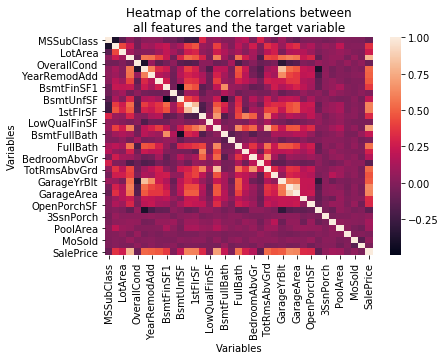

In [33]:
sns.heatmap(corr_df.corr()).set_title('Heatmap of the correlations between\nall features and the target variable') 
plt.xlabel('Variables') 
plt.ylabel('Variables')

Again, a lot to digest here. We can't see the numbers but we can see that certain features are highly correlated with one another (those are pockets of light colors) and certain features appear to be better correlated with our target variable. There is still a lot to see here, however, so lets approach this from a different angle. Let's look at just the correlations with `SalePrice` and order them from highest to lowest. 

In [34]:
corr_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

As we can clearly see some features are really correlated with `SalePrice` (like `OverallQual`) while others are not at all (like `KitchenAbvGr`). Now that we have a better idea, let's pick a handful of features and `SalePrice` and reexamine the correlation matrix via a heatmap.

In [35]:
corr_sample_df = corr_df[['OverallQual','YearBuilt', 'OverallCond', 'EnclosedPorch', 'SalePrice']]

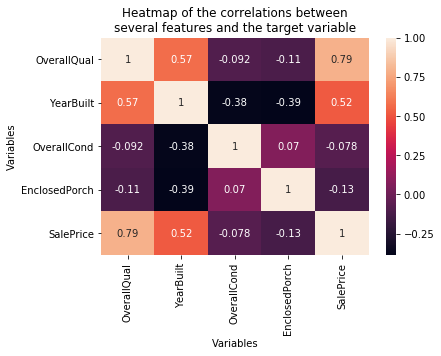

In [36]:
sns.heatmap(corr_sample_df.corr(), annot=True).set_title('Heatmap of the correlations between\nseveral features and the target variable') 
plt.xlabel('Variables') 
plt.ylabel('Variables')

Ah, this is a lot better and easier to understand! From this we can clearly see that some features are much more highly correlated with `SalePrice` than others. On top of this, we can also see that certain features are highly correlated with one another while others are not correlated with each other at all. Most striking for me is the fact that `OverallQual` is not correlated with `OverallCond`!

Besides plotting heatmaps, I like to go one step further and plot pairplots to really understand individual features and how they are correlated with one another. That is done below: 

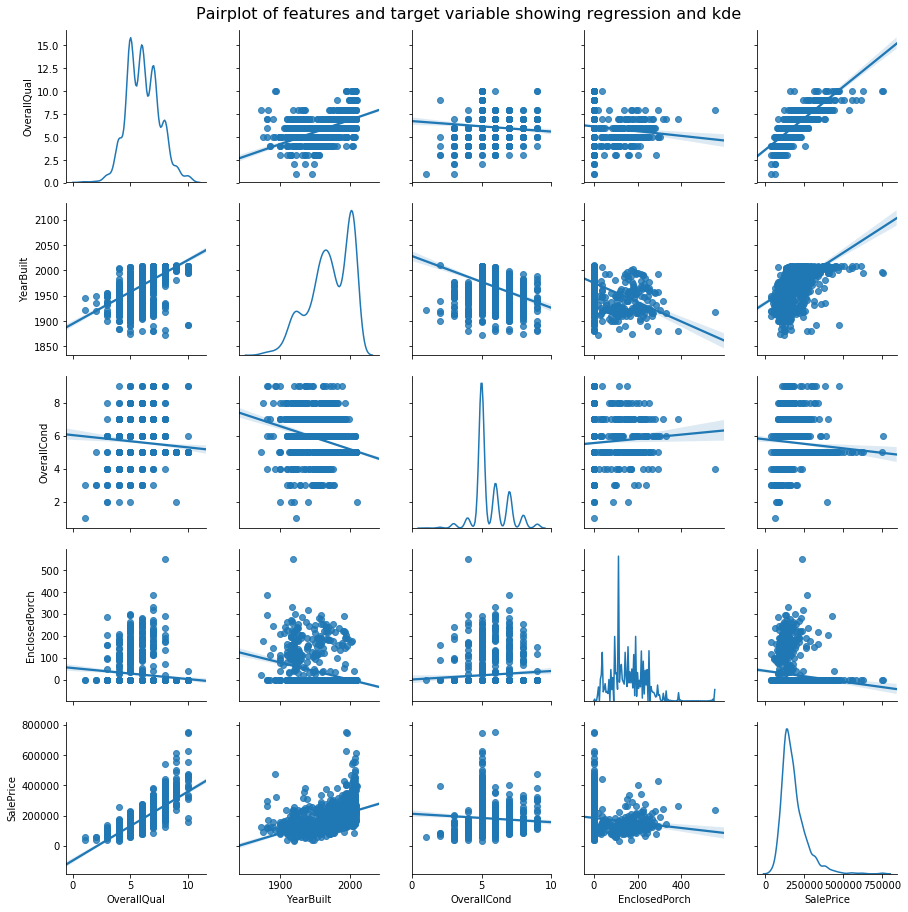

In [37]:
g = sns.pairplot(corr_sample_df, diag_kind="kde", kind='reg')
g.fig.suptitle("Pairplot of features and target variable showing regression and kde", y=1.01, fontsize=16)

With this plot, we can now see how certain features are highly correlated with `SalePrice`. Interestingly, in the case of `OverallQual`, although the correlation is high, the pairplot suggests the relationship may actually be closer to being a non-linear one rather than a linear one. Again, this is something we couldn't have deduced just by looking at the heatmap! On top of that, we can also see how certain features are highly skewed as well. 

## Conclusions 

And that brings us to the end of my EDA. Taken together this process has revealed important insights such as potential pitfalls (missing and skewed data) as well as particular features that look promising and merit including in our model. 